In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from pathlib import Path
import rerun as rr
from b3d.utils import keysplit


key = jax.random.PRNGKey(0)

In [3]:
from b3d.chisight.sfm.datasets import TumRgbdData


root = Path("/home/mirkoklukas/workspace/data/rgbd_slam_dataset_freiburg")
datasets = TumRgbdData._show_available_datasets(root)

Available datasets in /home/mirkoklukas/workspace/data/rgbd_slam_dataset_freiburg/...:
(0) rgbd_dataset_freiburg3_sitting_static
(1) rgbd_dataset_freiburg1_xyz
(2) rgbd_dataset_freiburg3_long_office_household


Sequence rgbd_dataset_freiburg3_long_office_household already exists.
Num Frames: 2585


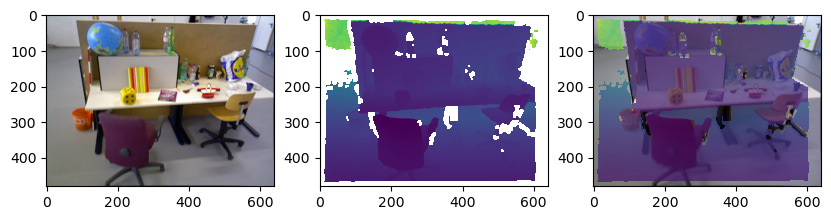

In [4]:
# sequence_name = datasets[0]
sequence_name = "rgbd_dataset_freiburg3_long_office_household"

# Download the sequence
sequence_url = TumRgbdData._sequence_url_from_sequence_name(sequence_name)
sequence_folder = TumRgbdData._download_from_url(sequence_url, root)
path = root/sequence_name
data = TumRgbdData(path)

# Get the i'th RGB image
# Note that rgb, depth, and pose sequences are not synchronized, so the i'th RGB image
# and the i'th depth image and pose are not guaranteed to be from the same time.
i = 100
rgb = data.get_rgb(i)

print(f"Num Frames: {len(data)}")

# This returns i'th RGB image and the CLOSEST (in time) available depth image and pose
rgb, depth, pose = data.get_synced(i)
# ==============================================
# Plot the RGB and depth images side by side
fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].imshow(rgb)
axs[1].imshow(np.where(depth>0, depth, np.nan))
axs[2].imshow(rgb, alpha=1.)
axs[2].imshow(np.where(depth>0, depth, np.nan), alpha=0.75);

In [5]:
from b3d.chisight.sfm.utils import (
    rescale_pose,
    rescale_poses,
    reproject_using_depth,
    xq_dist,
    xq_cos,
    vmap_uniform_pose,
)
from b3d.chisight.sfm.plotting_utils import (
    log_pose,
)
from b3d.chisight.sfm.opencv_wrapper import (
    matched_only_sift as matched_sift_cv,
    detect_and_match_sift as detect_and_match_sift_cv,
    recover_pose,
    find_essential,
    infer_pose as infer_pose_cv,
    infer_pose_and_inlier as infer_pose_and_inlier_cv,
)
from b3d.chisight.sfm.eight_point import (
    normalized_eight_point,
    normalized_eight_point_with_constraints,
    find_best_chirality,
    poses_from_essential,
    essential_from_pose,
    essential_constraints,
    enforce_internal_constraint,
    triangulate_linear_hartley,
)
from b3d.chisight.sfm.epipolar import( 
    epipolar_image_distances,
)
from b3d.pose import Pose

from b3d.camera import (
    Intrinsics, 
    camera_matrix_from_intrinsics, 
    camera_from_screen, 
    screen_from_camera,
    screen_from_world,
)




intr  = Intrinsics.from_array(data.get_intrinsics())
cam_K = camera_matrix_from_intrinsics(intr)
cam_K_inv = jnp.linalg.inv(cam_K)


      Pos  diff   0.19, 
      Quat diff   0.04



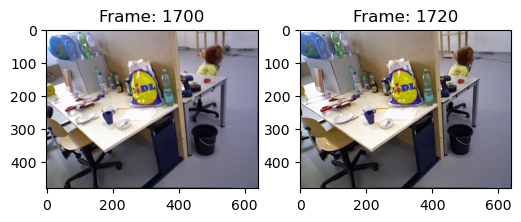

In [6]:
t0 = [2140, 1700, 1500, 1200, 600, 150, 40, 350][1] 
dt = 20
t1 = t0 + dt
t2 = t1 + dt


rgb, depth, cams = data[[t0,t1]]
p_true = cams[0].inv() @ cams[1]

# ==============================================
print(f"""
      Pos  diff  {xq_dist(cams[0], cams[1])[0]:>5.2f}, 
      Quat diff  {xq_dist(cams[0], cams[1])[1]:>5.2f}
""")
data.plot_multiple_frames([t0,t1], axs=None);

In [7]:
(uvs0_all, fs0, inds0), (uvs1_all, fs1, inds1) = detect_and_match_sift_cv(rgb[0], rgb[1])
uvs0 = uvs0_all[inds0]
uvs1 = uvs1_all[inds1]


ys0 = camera_from_screen(uvs0, intr)
ys1 = camera_from_screen(uvs1, intr)

print(uvs0.shape)

(255, 2)


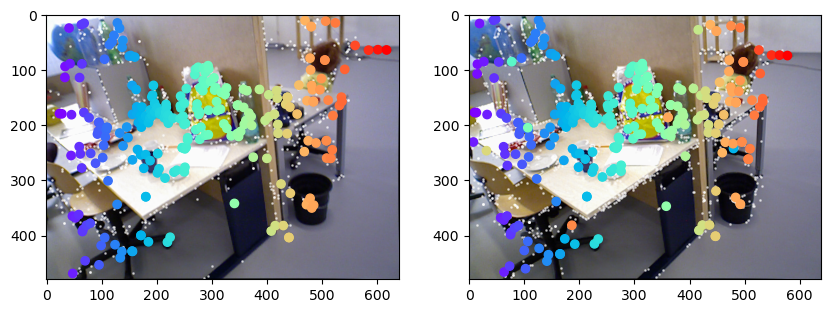

In [8]:
uvs1_, valid = reproject_using_depth(uvs0, depth[0], p_true, intr)
sub = valid


# ==============================================
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
ax.imshow(rgb[0])
ax.scatter(uvs0_all[:,0] , uvs0_all[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs0[:,0] , uvs0[:,1], c=uvs0[:, 0], cmap="rainbow")
ax = axs[1]

ax.imshow(rgb[1])
ax.scatter(uvs1_all[:,0] , uvs1_all[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs1[:,0] , uvs1[:,1], c=uvs0[:, 0], cmap="rainbow")

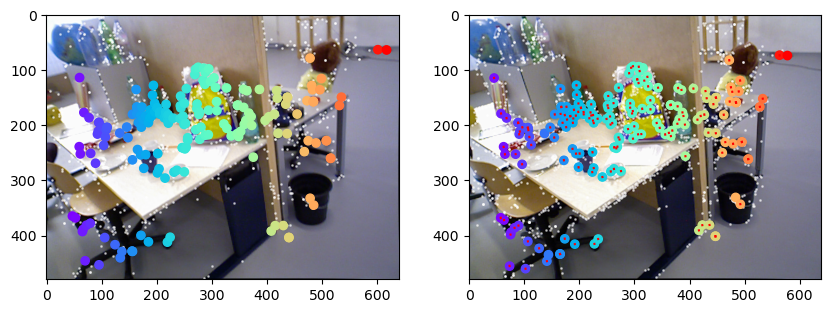

In [9]:
p_cv, inlier_cv = infer_pose_and_inlier_cv(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)
xs = triangulate_linear_hartley(Pose.id(), p_cv, ys0, ys1)
uvs1_ = screen_from_world(xs, p_cv, intr)

# ==============================================
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
ax.imshow(rgb[0])
ax.scatter(uvs0_all[:,0] , uvs0_all[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs0[inlier_cv,0] , uvs0[inlier_cv,1], c=uvs0[inlier_cv, 0], cmap="rainbow")

ax = axs[1]
ax.imshow(rgb[1])
ax.scatter(uvs1_all[:,0] , uvs1_all[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs1[inlier_cv,0] , uvs1[inlier_cv,1], c=uvs0[inlier_cv, 0], cmap="rainbow")

ax.plot(np.stack([uvs1[inlier_cv,0], uvs1_[inlier_cv,0]]), np.stack([uvs1[inlier_cv,1], uvs1_[inlier_cv,1]]), c="r");


In [505]:


# =============
rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)
rr.log(f"Triangulated", rr.Points3D(cams[0](xs), colors=[1.,1.,1.], radii=.05))
rr.log(f"Triangulated_inlier", rr.Points3D(cams[0](xs[inlier_cv]), colors=[1.,0.,1.], radii=.07))
log_pose("Pose[0]", cams[0], scale=0.5)
log_pose("Pose[1]", cams[1], scale=0.5)
log_pose("Pose[1]'", cams[0]@rescale_pose(p_cv, p_true), scale=0.5)

In [667]:
def func(t0, t1):
    rgb, depth, cams = data[[t0,t1]]
    (uvs0_all, fs0, inds0), (uvs1_all, fs1, inds1) = detect_and_match_sift_cv(rgb[0], rgb[1])
    uvs0 = uvs0_all[inds0]
    uvs1 = uvs1_all[inds1]
    p_cv, inlier_cv = infer_pose_and_inlier_cv(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)
    return {
        "rgb": rgb, 
        "depth": depth, 
        "cams": cams, 
        "inferred_pose": p_cv,
        "uvs0": uvs0,
        "uvs1": uvs1,
        "inlier": inlier_cv,
        "uvs0_all": uvs0_all,
        "uvs1_all": uvs1_all,
        "inds0": inds0,
        "inds1": inds1,
        }



dt = 40
# 2140
ts = [2140 + i*dt for i in range(3)]
objs = []
for (t0,t1) in zip(ts[:-1], ts[1:]):
    print(t0,t1)
    objs.append(func(t0, t1))

ps = [Pose.id()]
for p in [o["inferred_pose"] for o in objs]: 
    print(p)
    ps.append(ps[-1] @ p)
ps = Pose.stack_poses(ps)


cams = [objs[0]["cams"][0]]
for p in [o["cams"][1] for o in objs]: 
    cams.append(p)
cams = Pose.stack_poses(cams)

2140 2180
2180 2220
Pose(position=Array([ 0.17078036,  0.19642425, -0.96553165], dtype=float32), quaternion=Array([ 0.04088708, -0.19120288, -0.1727764 , -0.965359  ], dtype=float32))
Pose(position=Array([-0.19521505,  0.25438496, -0.9471957 ], dtype=float32), quaternion=Array([-0.02887738, -0.07093167, -0.06929317, -0.9946524 ], dtype=float32))


In [668]:
s0, s1 = jnp.linalg.norm( cams.pos[:-1] - cams.pos[1:], axis=1)
s0, s1

(Array(0.26454526, dtype=float32), Array(0.36130032, dtype=float32))

In [10]:
def get_angle(p, p1, p2):
    a = p1.pos - p.pos
    b = p2.pos - p.pos
    a = a/jnp.linalg.norm(a)
    b = b/jnp.linalg.norm(b)
    return jnp.arccos(jnp.dot(a,b))

def infer_and_angle(t0, t1, t2):
    p0 = Pose.id()
    p1 = func(t0, t1)["inferred_pose"]
    p2 = func(t0, t2)["inferred_pose"]
    return get_angle(p0, p1, p2), p1, p2

# def scale(p0, p1, p2, c = 1.):
#     alpha = get_angle(p0, p1, p2)
#     beta  = get_angle(p1, p0, p2)
#     gamma = jnp.pi - alpha - beta
#     a = jnp.sin(alpha) * c/jnp.sin(gamma)
#     b = jnp.sin(beta) * c/jnp.sin(gamma)
#     return a, b, (a+b)/2, np.sum([alpha, beta, gamma])


def scale_from_angles(alpha, beta, c=1):
    gamma = jnp.pi - alpha - beta
    a = jnp.sin(alpha) * c/jnp.sin(gamma)
    b = jnp.sin(beta)  * c/jnp.sin(gamma)
    return a,b


def scale_triplet(t0, t1, t2, s0=1):
    alpha, _,_ = infer_and_angle(t0, t1, t2)
    beta, _,_ = infer_and_angle(t1, t0, t2)

    print(alpha/jnp.pi, beta/jnp.pi)

    return scale_from_angles(alpha, beta, c=s0)


s1, scale_triplet(*ts, s0=s0)

NameError: name 's1' is not defined

In [11]:
s0, s1 = jnp.linalg.norm( cams.pos[:-1] - cams.pos[1:], axis=-1)
s0, s1

ValueError: not enough values to unpack (expected 2, got 1)

In [596]:
jnp.linalg.norm( ps.pos[1:] - ps.pos[:-1], axis=-1)

Array([1.       , 1.0000002], dtype=float32)

In [601]:

ps.shape



scale(ps[0], ps[1], ps[2], c= s0)

(Array(0.51867014, dtype=float32),
 Array(0.6730513, dtype=float32),
 Array(0.5958607, dtype=float32),
 3.1415925)

In [594]:
ps = [Pose.id()]
for p in [o["inferred_pose"] for o in objs]:
    ps.append(ps[-1] @ p)

ps = Pose.stack_poses(ps)
ps.shape

# =============
rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)
rr.log(f"Triangulated", rr.Points3D(cams[0](xs), colors=[1.,1.,1.], radii=.05))
rr.log(f"Triangulated_inlier", rr.Points3D(cams[0](xs[inlier_cv]), colors=[1.,0.,1.], radii=.07))

log_pose("True[0]", objs[0]["cams"][0], scale=0.5)

for i,p in enumerate([o["cams"] for o in objs]):
    log_pose(f"True[{i+1}]", p[1], scale=.5)


for i,p in enumerate(ps):
    log_pose(f"Inf[{i}]", cams[0]@p, scale=0.5)

In [12]:
def random_choices(key, num_choices, shape):
    """
    Example:
    ```
    # Create 1000 samples of 8 random indices
    inds = random_choices(key, 100, (1_000, 8))
    assert inds.shape == (1000,8)
    ```
    """
    assert len(shape) <= 2
    _, keys = keysplit(key, 1, shape[0])
    return jax.vmap(lambda key: jax.random.choice(key, num_choices, shape[1:], replace=False))(keys)

In [16]:
def put_pose_on_S2(p):
    return Pose(p.pos/jnp.linalg.norm(p.pos), p.quat)

In [14]:
key = keysplit(key)
xs = jax.random.normal(key, (100_000,3))
xs = xs / jnp.linalg.norm(xs, axis=-1, keepdims=True)


: 

In [24]:
from b3d.chisight.sfm.eight_point import pose_variations
from b3d.chisight.sfm.opencv_wrapper import (
    matched_only_sift,
    detect_and_match_sift,
    recover_pose,
    find_essential,
    infer_pose,
    infer_pose_and_inlier,
    detect_sift,
    detect_orb,
    match_bf,
)

def exp1(inds):
    ps = []
    for ii in inds:
        E = normalized_eight_point(ys0[ii], ys1[ii])
        p = recover_pose(E, uvs0, uvs1, cam_K)
        ps.append(p)

    return Pose.stack_poses(ps)


def _exp2(ii, thresh=1.):

    E = normalized_eight_point(ys0[ii], ys1[ii])


    errs= epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    inlier =  errs < thresh
    # score = - jnp.(errs*inlier)/jnp.sum(inlier)
    score = jnp.sum(inlier)
    ps = poses_from_essential(E)
    # p,_ = find_best_chirality(ps, ys0, ys1)

    return E, ps, score*jnp.ones(4), jnp.ones(4)

exp2 = jax.jit(jax.vmap(_exp2, (0, None)))



def _exp3(ii, thresh=1.):

    E = normalized_eight_point(ys0[ii], ys1[ii], normalize=False, enforce_constraint=False)
    ps = poses_from_essential(E)
    errs= epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    inlier =  errs < thresh
    inlier_count = jnp.sum(inlier)
    mean_err = jnp.where(inlier, errs, 4*thresh).mean()

    return E, ps, inlier_count*jnp.ones(4), mean_err*jnp.ones(4)


exp3 = jax.jit(jax.vmap(_exp3, (0, None)))


def _exp4(ii, thresh=1.):

    E = normalized_eight_point(ys0[ii], ys1[ii], normalize=False, enforce_constraint=False)
    errs= epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    inlier =  errs < thresh
    inlier_count = jnp.sum(inlier)
    mean_err = jnp.where(inlier, errs, 4*thresh).mean()

    return E, inlier_count, mean_err


exp4 = jax.jit(jax.vmap(_exp4, (0, None)))

In [32]:
import scipy
from b3d.chisight.sfm.opencv_wrapper import infer_pose, infer_essential


print(f"{scipy.special.comb(len(uvs0), 8):_.0f}")

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2_000, 8))


%timeit -n 1 -r 1 jax.block_until_ready(exp3(inds, 10.));
%timeit -n 1 -r 1 jax.block_until_ready(exp4(inds, 10.));

%timeit -n 1 -r 1 infer_essential(uvs0, uvs1, cam_K, prob=.9999, threshold=1., max_iters=1_000);
%timeit -n 1 -r 1 infer_pose(uvs0, uvs1, cam_K, prob=.9999, threshold=1., max_iters=1_000);

396_861_704_798_625
4.36 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
14.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
51.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Score 0.0 39.0
Err 0.3477203 0.40000007
(Array(0.9957474, dtype=float32), Array(0.9999743, dtype=float32))
(Array([ 0.92114836,  0.9212054 , -0.92114836, -0.9212054 ], dtype=float32), Array([0.9999774 , 0.00141975, 0.9999774 , 0.00141975], dtype=float32))


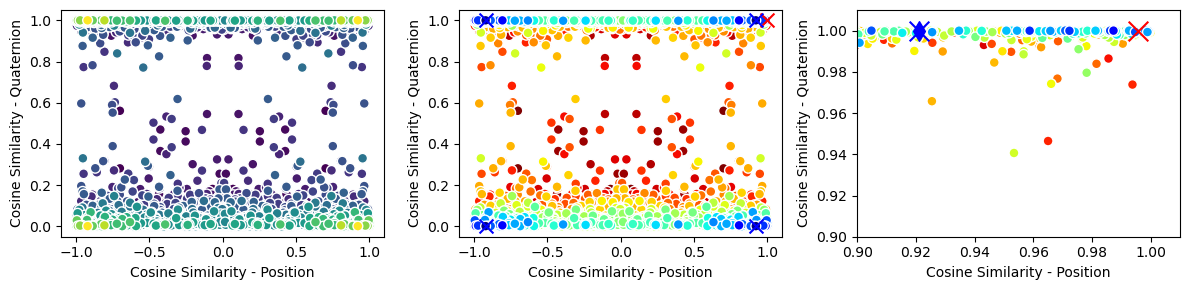

In [19]:

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2_000, 8))


p_cv = infer_pose(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)

%timeit -n 1 -r 1 jax.block_until_ready(exp3(inds, 10.));

Es, ps, scores, errs = exp3(inds, jnp.array(.1))
ps = ps.reshape(-1)
scores = scores.reshape(-1) 
errs = errs.reshape(-1)
# perm = jnp.argsort(errs)[::-1]
perm = jnp.argsort(scores)

Es = Es[perm]
ps = ps[perm]
scores = scores[perm]
errs = errs[perm]





print("Score", scores.min(), scores.max())
print("Err", errs.min(), errs.max())
print(xq_cos(p_cv, p_true))
print(xq_cos(ps[-4:], p_true))

metric = xq_cos

fig, axs = plt.subplots(1,3,figsize=(12,3))



ax = axs[0]
ax.set_xlabel("Cosine Similarity - Position")
ax.set_ylabel("Cosine Similarity - Quaternion")
# ax.set_xlim(0.5, 1.02)
# ax.set_ylim(0.8, 1.02)
# ax.scatter(1,1, s=100, c="r", marker="s", alpha=0.5)
ax.scatter(*metric(ps, p_true), s=50, c=scores, alpha=1., cmap="viridis", edgecolor="w")
# ax.scatter(*metric(ps, p_true), s=10, c=-errs, alpha=1., cmap="viridis")
# ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")



k = 5*12
i_max_score = jnp.argmax(scores)
i_min_err_k = jnp.argmin(errs[-k:])
i_min_err = jnp.argmin(errs[:])


ax = axs[1]
ax.set_xlabel("Cosine Similarity - Position")
ax.set_ylabel("Cosine Similarity - Quaternion")
# ax.set_xlim(0.5, 1.02)
# ax.set_ylim(0.8, 1.02)
# ax.scatter(1,1, s=100, c="r", marker="s", alpha=0.5)
# ax.scatter(*metric(ps, p_true), s=10, c=scores, alpha=1., cmap="viridis")
ax.scatter(*metric(ps, p_true), s=50, c=errs, alpha=1., cmap="jet", edgecolor="w")
# ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")
ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")
# ax.scatter(*metric(pose_variations(ps[-k:][i_min_err_k]), p_true), s=100, c="b", marker="x")
ax.scatter(*metric(pose_variations(ps[i_min_err]), p_true), s=100, c="b", marker="x")


ax = axs[2]
ax.set_xlabel("Cosine Similarity - Position")
ax.set_ylabel("Cosine Similarity - Quaternion")
ax.set_xlim(0.9, 1.01)
ax.set_ylim(0.9, 1.01)



# i_min_err = jnp.argmax(scores[-k:])
# ax.scatter(1,1, s=200, c="lightgreen", marker="s", alpha=0.1)
ax.scatter(*metric(ps[:], p_true), s=50, c=errs[:], marker="o", cmap="jet", edgecolor="w", alpha=1.);
ax.scatter(*metric(p_cv, p_true), s=200, c="r", marker="x")
ax.scatter(*metric(pose_variations(ps[-k:][i_min_err_k]), p_true), s=100, c="b", marker="d")
ax.scatter(*metric(pose_variations(ps[i_min_err]), p_true), s=200, c="b", marker="x")
# ax.scatter(*metric(pose_variations(ps[i_max_score]), p_true), s=100, c="b", marker="d")

fig.tight_layout()

In [532]:
fi = jax.jit(find_best_chirality)

In [537]:
find_best_chirality(pose_variations(ps[i_min_err]), ys0, ys1)[0];
p1 = find_best_chirality(pose_variations(ps[i_min_err]), ys0, ys1)[0]

%timeit -n 1 -r 1 jax.block_until_ready(fi(pose_variations(ps[i_min_err]), ys0, ys1)[0]);


xq_cos(p1, p_true)

110 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


(Array(0.9991263, dtype=float32), Array(0.99994993, dtype=float32))

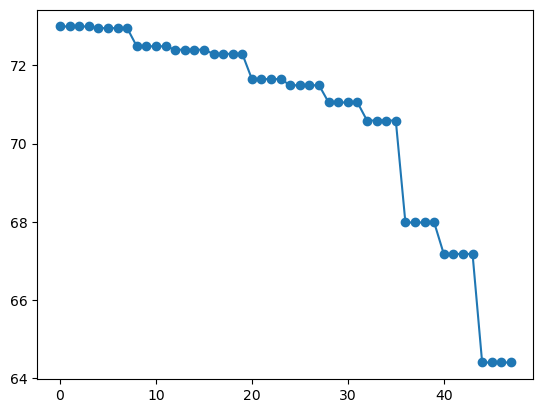

In [343]:
plt.plot(errs[-k:], marker="o")

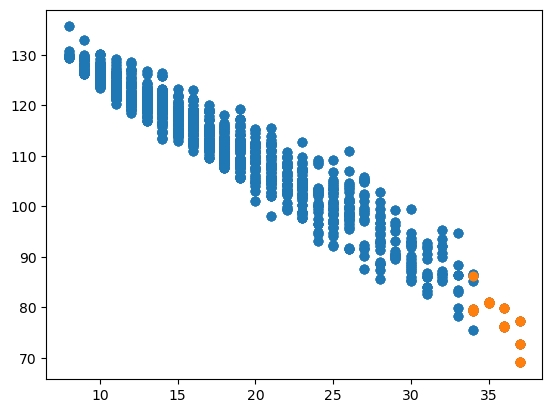

In [294]:
plt.scatter(scores, errs)
plt.scatter(scores[-k:], errs[-k:])

In [306]:
def _translation_scores(x, q):
    E = essential_from_pose(Pose(x, q))
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 5.1
    score = jnp.sum(inliers)
    return score

translation_scores = jax.jit(jax.vmap(_translation_scores, (0, None)))



def _scorer(p):
    E = essential_from_pose(p)
    errs = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    errs = jnp.clip(errs, 0.0, 4.5)

    return -errs

scorer = jax.jit(jax.vmap(_scorer))

69.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


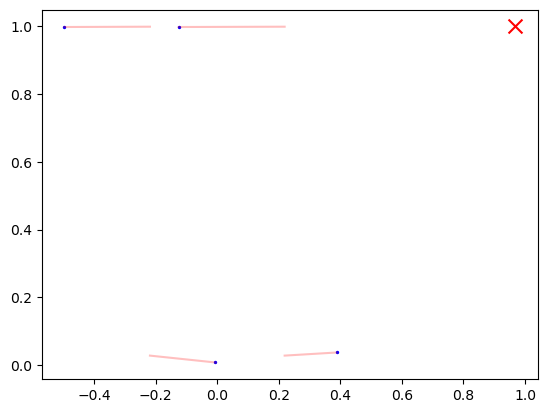

In [311]:
def improve_candidates(key, cands):
    improved = []
    for p in cands:


        # dx = xq_cos(p, p_true)

        key, keys = keysplit(key, 1, 1_000_000)
        qs = vmap_uniform_pose(keys, p, .8, 0.05)
        scores = scorer(qs)
        p_  = qs[jnp.argmax(scores)]

        improved.append(p_)

    return Pose.stack_poses(improved)



cands = pose_variations(ps[-k:][i_min_err])
# cands = ps[20:]
key = keysplit(key)
improved = improve_candidates(key, cands)
%timeit -n 1 -r 1 improve_candidates(key, cands);




plt.scatter(*xq_cos(p_cv, p_true), c="r", s=100, marker="x")
for p,p_ in zip(cands, improved):
    dx = xq_cos(p, p_true)
    dx_ = xq_cos(p_, p_true)
    plt.scatter(dx_[0], dx_[1], c="b", s=2)
    plt.plot([dx[0], dx_[0]], [dx[1], dx_[1]], c="r", alpha=0.25)

In [373]:
q0 = ps[-4 + 1].quat

key, keys = keysplit(key, 1, 100_000)
qs = vmap_uniform_pose(keys, Pose(jnp.zeros(3), q0), 1., 0.1)



scores = scorer(qs)

%timeit -n 1 -r 1 jax.block_until_ready(scorer(qs));


p = qs[jnp.argmax(scores)]

print(xq_cos(p, p_true))
print(xq_cos(Pose(-p.pos, p.quat), p_true))
# print(xq_cos(Pose(-x, q), p_true))


3.03 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
(Array(0.9473765, dtype=float32), Array(0.9798653, dtype=float32))
(Array(-0.9473765, dtype=float32), Array(0.9798653, dtype=float32))


In [ ]:

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2_000, 8))


p_cv = infer_pose_using_cv(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)

%timeit -n 1 -r 1 jax.block_until_ready(exp2(inds, 5.1));

Es, ps, scores = exp2(inds, jnp.array(1.))
ps = ps.reshape(-1)
scores = scores.reshape(-1) 
perm = jnp.argsort(scores)

Es = Es[perm]
ps = ps[perm]
scores = scores[perm]

qs = Pose.stack_poses([
    recover_pose_cv(E, uvs0, uvs1, cam_K) for E in Es[-20:]
])


print(xq_cos(p_cv, p_true))
print(xq_cos(ps[-4:], p_true))

metric = xq_cos

fig, axs = plt.subplots(1,2,figsize=(10,3))

ax = axs[0]
# ax.set_xlim(0.5, 1.02)
# ax.set_ylim(0.75, 1.02)
ax.scatter(1,1, s=100, c="r", marker="s", alpha=0.5)
ax.scatter(*metric(ps, p_true), s=10, c=scores, alpha=1., cmap="viridis")
# ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")

ax = axs[1]
# ax.set_xlim(0.9, 1.02)
ax.set_ylim(0.9, 1.02)


k = 100
ax.scatter(1,1, s=200, c="lightgreen", marker="s", alpha=0.5)
ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")
ax.scatter(*metric(ps[-k:], p_true), s=20, c=scores[-k:], marker=".");

In [311]:
import plotly.graph_objs as go
import numpy as np

# Assuming xs and cs are defined as numpy arrays
# xs should be of shape (N, 3)
# cs should be of shape (N,)

# Example data (replace with your actual data)
from jax.scipy.spatial.transform import Rotation as Rot



k = 200
euler_true = p_true.rot.as_euler("xyz")
# xs = ps[-k:].rot.as_euler("xyz")
xs = ps[-k:].quat[:,:3]
# xs = xs/jnp.linalg.norm(xs, axis=1)[:,None]
# xs = ps[-k:].pos
cs = metric(ps[-k:], p_true)[1]
# cs = scores[-k:]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=xs[:, 0],  # X axis
    y=xs[:, 1],  # Y axis
    z=xs[:, 2],  # Z axis
    mode='markers',
    marker=dict(
        size=5,
        color=cs,  # Color based on cs array
        colorscale='jet',  # Color scale
        # opacity=0.8,
        cmin=0.98,
        cmax=1.0,
    )
)])

# Set the layout for the plot
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    margin=dict(l=0, r=0, b=0, t=0)  # Tight layout
)

# Display the plot
fig.show()

(array([ 304.,  636.,  864., 1084., 1276., 1200., 1176., 1160., 1292.,
        1108., 1012.,  828.,  768.,  584.,  736.,  520.,  496.,  480.,
         416.,  380.,  348.,  272.,  324.,  252.,  216.,  280.,  244.,
         192.,  192.,  180.,  116.,  184.,   96.,  136.,  100.,   52.,
          96.,   52.,   84.,   20.,   32.,   40.,   36.,   16.,   16.,
          20.,   16.,   36.,    8.,   16.,    4.,    4.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59

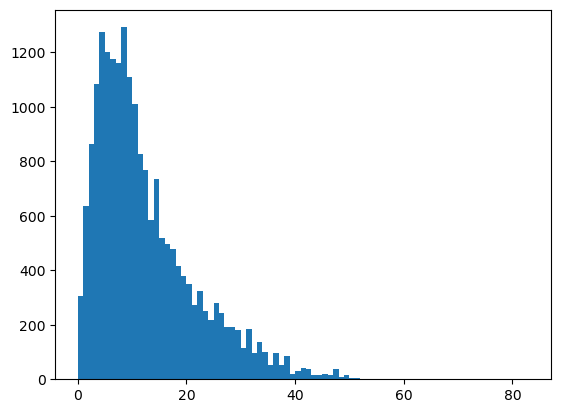

In [210]:
plt.hist(scores, bins=jnp.arange(len(uvs0)))

In [211]:

def _translation_scores(x, q):
    E = essential_from_pose(Pose(x, q))
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 5.1
    score = jnp.sum(inliers)
    return score

translation_scores = jax.jit(jax.vmap(_translation_scores, (0, None)))



def _scorer(p):
    E = essential_from_pose(p)
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 5.1
    score = jnp.sum(inliers)
    return score

scorer = jax.jit(jax.vmap(_scorer))

In [212]:
# xs = ps[-k:].quat[:,:3]

k = 5_000
xs = ps[-k:].rot.as_euler("xyz")
h, e = jax.numpy.histogramdd(xs, bins=[jnp.linspace(-jnp.pi*0.5, jnp.pi*0.5, 200)]*3)
e = jnp.stack(jnp.meshgrid(*e))
# h.shape
# quats = Rot.from_euler("xyz", xs).as_quat()

# plt.scatter(*metric(ps[-k:], p_true), s=20, c=scores[-k:], marker=".");
# qs.shape

jnp.argmax(h)

i = jnp.unravel_index(jnp.argmax(h), h.shape)
# e[:, i[0], i[1], i[2]]
e[:,*i]

xq_cos(Pose(jnp.ones(3), Rot.from_euler("xyz", e[:,*i]).as_quat()), p_true)
# xq_cos(Pose(jnp.ones(3), Rot.from_euler("xyz", e[:, i[0]+1, i[1]+1, i[2]+1]).as_quat()), p_true)



q0 = Rot.from_euler("xyz", e[:,*i]).as_quat()


print(xq_cos(Pose(jnp.zeros(3), q0), p_true))

(Array(nan, dtype=float32), Array(0.9809245, dtype=float32))


(Array(0.5536579, dtype=float32), Array(0.9806936, dtype=float32))
(Array(-0.5536579, dtype=float32), Array(0.9806936, dtype=float32))


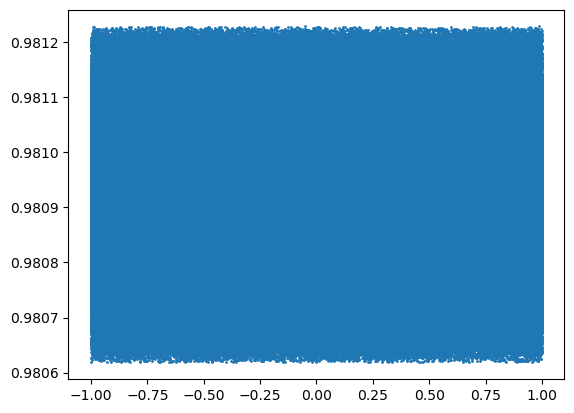

In [213]:



key, keys = keysplit(key, 1, 1_000_000)
qs = vmap_uniform_pose(keys, Pose(jnp.zeros(3), q0), 1., 0.001)


scores = scorer(qs)
p = qs[jnp.argmax(scores)]

# key = keysplit(key)
# xs = jax.random.normal(key, (1_000_000,3))
# xs = xs / jnp.linalg.norm(xs, axis=-1, keepdims=True)

# xs = xs.at[0].set(p_true.pos)

# print(xs.shape)



# %timeit -n 1 -r 1 jax.block_until_ready(translation_scores(xs, q));


# scores = translation_scores(xs, p_true.quat)
# x = xs[jnp.argmax(scores)]
# x = xs[0]

# print(scores[:10])


# print(xq_cos(Pose.id(), p_true))
# print(xq_cos(p_cv, p_true))
# print(xq_cos(Pose(x, q), p_true))
# print(xq_cos(Pose(-x, q), p_true))
# print(xq_cos(Pose(p_true.pos*0.1, q), p_true))


# plt.plot(scores[:40])

print(xq_cos(p, p_true))
print(xq_cos(Pose(-p.pos, p.quat), p_true))
# print(xq_cos(Pose(-x, q), p_true))

plt.scatter(*xq_cos(qs, p_true), s=1)

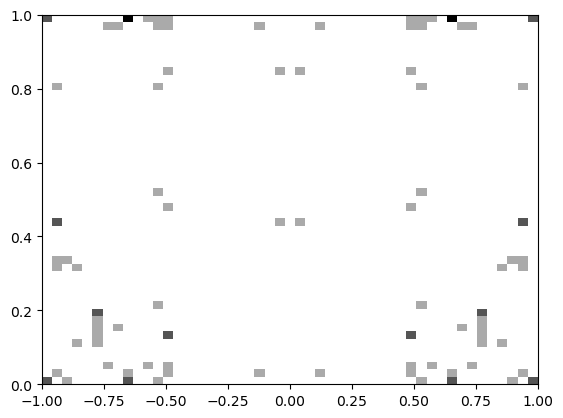

In [31]:
plt.hist2d(*metric(ps[-100:], p_true), 
           bins=[
               np.linspace(-1.,1.,50), 
               np.linspace(0.,1.,50)
            ], 
            cmap="binary");

# plt.scatter(*metric(p_cv, p_true), c="r", marker="x", clip_on=False);

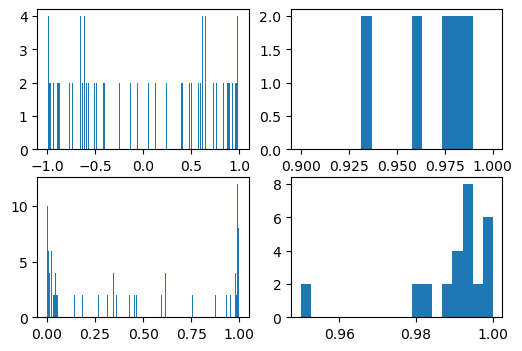

In [34]:
k = 100

fig, axs = plt.subplots(2,2,figsize=(6,4))
axs[0,0].hist(metric(ps[-k:], p_true)[0], bins=np.linspace(-1,1.,200));
axs[1,0].hist(metric(ps[-k:], p_true)[1], bins=np.linspace(0, 1.,200));

axs[0,1].hist(metric(ps[-k:], p_true)[0], bins=np.linspace(.9,1.,20));
axs[1,1].hist(metric(ps[-k:], p_true)[1], bins=np.linspace(.95,1.,20));

6.79 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


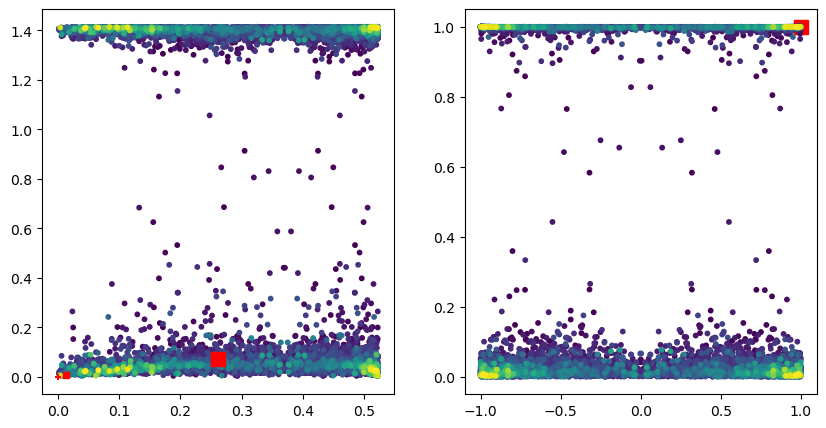

In [148]:

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2500, 8))


p_cv = infer_pose_using_cv(uvs0, uvs1, cam_K, prob=.999999, threshold=1.0, max_iters=1000)
p_cv = rescale_pose(p_cv, p_true)

p_id = rescale_pose(Pose.id(), p_true)

%timeit -n 1 -r 1 jax.block_until_ready(exp2(inds));
ps2, errs = exp2(inds)
ps2 = ps2.reshape(-1)
errs = errs.reshape(-1) 
perm = jnp.argsort(errs)[:]
ps2 = ps2[perm]
errs = errs[perm]
ps2 = rescale_poses(ps2, p_true)



fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].scatter(*jax.vmap(xq_dist, (0, None))(ps2, p_true), s=10, c=errs, alpha=1., cmap="viridis")

axs[0].scatter(0,0, s=20, c="r", marker="+")
axs[0].scatter(*xq_dist(p_cv, p_true), s=20, c="r", marker="s")
axs[0].scatter(*xq_dist(Pose.id(), p_true), s=100, c="r", marker="s")


axs[1].scatter(1,1, s=100, c="r", marker="s")
axs[1].scatter(*jax.vmap(xq_cos, (0, None))(ps2, p_true), s=10, c=errs, alpha=1., cmap="viridis")